## 
This notebook goes through the detected duplicate candidate pairs from *dup_detection.ipynb* and runs a decision process whether to keep or reject the identified records. 

Output: 
- Decision file : dup_detection/DATABASENAME/duplicate_decisions_DATABASENAME_AUTHORINITIALS_YY-MM-DD.csv
- duplicate free dataframe: dup_detection/DABASENAME_dup_free.pkl

27/11/2024 LL: Changed hierarchy FE23>PAGES 2k
22/10/2024 v1: Updated the decision process:
    - created backup decision file which is intermediately saved
    - outputs URL which can be copied and pasted into browser
    - implemented a composite option in the decision process, to create a composite of two records
27/9/2024 v0: Notebook written by Lucie Luecke 



# Set up environment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import pickle
# import gzip
import os
import pandas as pd
# import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
from matplotlib.gridspec import GridSpec as GS
from copy import deepcopy as dc
import functions as f
import geopy
import datetime
import f_duplicate_search as dupdet

In [3]:
# choose working directory
wdir = '/home/jupyter-lluecke/compile_proxy_database_v2.1'
os.chdir(wdir)
print(wdir)

/home/jupyter-lluecke/compile_proxy_database_v2.1


## Load dataset

In [4]:
# read dataframe 

db_name = 'dod2k_dupfree'
#db_name = 'dod2k'
#db_name = 'ch2k'
# db_name = 'fe23'
# db_name = 'iso2k'
# db_name = 'pages2k'
# db_name = 'sisal'


# load dataframe
df = f.load_compact_dataframe_from_csv(db_name)
# databasedir    = '%s/%s_compact.pkl'
# df = pd.read_pickle(databasedir)

print(df.info())
df.name = db_name


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4517 entries, 0 to 4516
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   DuplicateDetails                      4517 non-null   object 
 1   archiveType                           4517 non-null   object 
 2   climateInterpretation_variable        4517 non-null   object 
 3   climateInterpretation_variableDetail  4517 non-null   object 
 4   dataSetName                           4517 non-null   object 
 5   datasetId                             4517 non-null   object 
 6   geo_meanElev                          4434 non-null   float32
 7   geo_meanLat                           4517 non-null   float32
 8   geo_meanLon                           4517 non-null   float32
 9   geo_siteName                          4517 non-null   object 
 10  originalDataURL                       4517 non-null   object 
 11  originalDatabase 

In [5]:
# for ii in df.index:
#     if type(df.at[ii, 'paleoData_values'])==np.ma.core.MaskedArray: continue
#     dd=f.convert_to_nparray(df.at[ii, 'paleoData_values'])
#     df.at[ii, 'paleoData_values']=dd.data[~dd.mask]
#     df.at[ii, 'year']=df.at[ii, 'year'][~dd.mask]

In [6]:
# print('databasedir:', data basedir)
print('db_name:', df.name)

db_name: dod2k_dupfree


# Duplicate Detection

### Hierarchy for duplicate removal for identical duplicates

In [7]:
print(df.originalDatabase.unique())

['FE23 (Breitenmoser et al. (2014))' 'CoralHydro2k v1.0.0' 'Iso2k v1.0.1'
 'PAGES2k v2.0.0 (Ocn_103 updated with Dee et al. 2020)' 'SISAL v3'
 'dod2k_composite_standardised']


In [8]:
# implement hierarchy for automated decisions for identical records
df['Hierarchy'] = 0 
df.loc[df['originalDatabase']=='PAGES2k v2.0.0 (Ocn_103 updated with Dee et al. 2020)', 'Hierarchy'] = 5
df.loc[df['originalDatabase']=='FE23 (Breitenmoser et al. (2014))', 'Hierarchy'] = 4
df.loc[df['originalDatabase']=='CoralHydro2k v1.0.0', 'Hierarchy'] = 2
df.loc[df['originalDatabase']=='Iso2k v1.0.1', 'Hierarchy'] = 3
df.loc[df['originalDatabase']=='SISAL v3', 'Hierarchy'] = 1

### Run through duplicate candidates and decide whether to keep or reject.

In [9]:
# # write your details here or comment out and write as input in next cell
# initials = 'MNE'
# fullname = 'Michael Neil Evans'
# email    = 'mnevans@umd.edu'
# operator_details = [initials, fullname, email]

In [10]:
# print('SAVE OPERATOR DETAILS FOR DECISION PROCESS.')
try:
    print(operator_details)
except:
    initials = input('Please enter your initials here:')
    fullname = input('Please enter your full name here:')
    email    = input('Please enter your email address here:')
    operator_details = [initials, fullname, email]

Please enter your initials here: MNE
Please enter your full name here: Michael Neil Evans
Please enter your email address here: mnevans@umd.edu


In [11]:

date = str(datetime.datetime.utcnow())[2:10]

try:
    open('%s/dup_detection/dup_decisions_%s_%s_%s_BACKUP.csv'%(df.name, df.name, initials, date), 'r')
except FileNotFoundError:
    print('No BACKUP FILE FOUND.')
    print('The duplicate decision process will therefore start from scratch.')
    yn=''
    while yn not in ['y', 'n']:
        yn=input('Are you happy to start the decision process from scratch? [y/n]')
        if yn=='n':
            print('If you wish to continue from a previous decision process, please read the following instructions:'.upper())
            print('1. Choose the backup file you wish to continue from.')
            print('2. Duplicate or copy and paste this file to create an identical copy.')
            print('3. Change the datestamp in the filename of the new backup file to TODAY\'s date: %s.'%date)
            print('4. The filename should read: dup_decisions_%s_%s_%s_BACKUP.csv'%(df.name, initials, date))
            print('5. You can now proceed with the next line of code which will continue the decision process where you left off.')
        elif yn=='y':
            print('Start decision process from scratch!'.upper())
        else:
            print('Please type one of the following options: y(es) or n(o)!')
    


    

No BACKUP FILE FOUND.
The duplicate decision process will therefore start from scratch.


Are you happy to start the decision process from scratch? [y/n] y


START DECISION PROCESS FROM SCRATCH!


# go through the dups and make decisions for each candidate pair (except for recollections or updates which are automatically selected)
# save decision for each record in csv. Provide link to figure in csv.
# show decisions and confirm 
dupdet.duplicate_decisions(df, operator_details=operator_details)


Please enter your initials here: MNE
Please enter your full name here: Michael Neil Evans
Please enter your email address here: mnevans@umd.edu


No back up.
header for backup [['# Decisions for duplicate candidate pairs. '], ['# Operated by Michael Neil Evans (MNE)'], ['# E-Mail: mnevans@umd.edu'], ['# Created on: 2024-12-05 21:06:19.972710 (UTC)']]
cols for backup [['index 1', 'index 2', 'figure path', 'datasetId 1', 'datasetId 2', 'originalDatabase 1', 'originalDatabase 2', 'geo_siteName 1', 'geo_siteName 2', 'geo_meanLat 1', 'geo_meanLat 2', 'geo_meanLon 1', 'geo_meanLon 2', 'geo_meanElevation 1', 'geo_meanElevation 2', 'archiveType 1', 'archiveType 2', 'paleoData_proxy 1', 'paleoData_proxy 2', 'originalDataURL 1', 'originalDataURL 2', 'year 1', 'year 2', 'Decision 1', 'Decision 2', 'Decision type', 'Decision comment']]
data for backup []
> 1/3,FE23_asia_russ137w,dod2k_composite_st_pages2k_Asia_011_pages2k_Asia_012,0.37072945852236205,0.9968733897185018
=== POTENTIAL DUPLICATE 0/3: FE23_asia_russ137w+dod2k_composite_st_pages2k_Asia_011_pages2k_Asia_012 ===
=== URL 1: https://www.ncei.noaa.gov/pub/data/paleo/treering/measurem

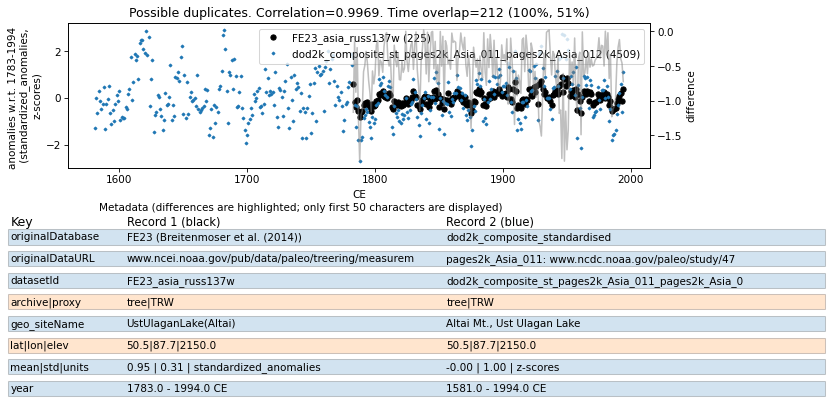

Would you like to leave a comment?


 Please type your comment here and/or press enter. choose record 2 composite that includes record 1
Keep record 1 (FE23_asia_russ137w, black) [1], record 2 (dod2k_composite_st_pages2k_Asia_011_pages2k_Asia_012, blue) [2], keep both [b], keep none [n] or create a composite of both records [c]?  [Type 1/2/b/n/c]: 2


KEEP BLACK: remove FE23_asia_russ137w, keep dod2k_composite_st_pages2k_Asia_011_pages2k_Asia_012.
write decision to backup file
> 2/3,iso2k_IC09OPAN01A,pages2k_Arc_089,0.0,0.9865701575318525
=== POTENTIAL DUPLICATE 1/3: iso2k_IC09OPAN01A+pages2k_Arc_089 ===
=== URL 1: https://doi.pangaea.de/10.1594/pangaea.871279   ===
=== URL 2: https://doi.pangaea.de/10.1594/PANGAEA.824732   ===
metadata_identical:  False
lat True lon True elevation True archivetype True paleodata_proxy False
sites_identical:  False
URL_identical:  False
data_identical:  False
correlation_perfect:  False


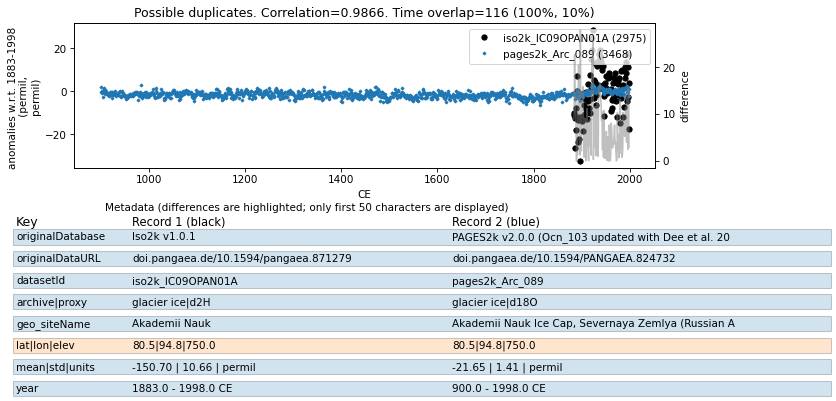

Would you like to leave a comment?


 Please type your comment here and/or press enter. d2H and d18O records, keep both
Keep record 1 (iso2k_IC09OPAN01A, black) [1], record 2 (pages2k_Arc_089, blue) [2], keep both [b], keep none [n] or create a composite of both records [c]?  [Type 1/2/b/n/c]: b


KEEP BOTH: keep iso2k_IC09OPAN01A, keep pages2k_Arc_089.
write decision to backup file
> 3/3,pages2k_Ant_031,pages2k_Ant_031dD,0.0,0.9929273845409058
=== POTENTIAL DUPLICATE 2/3: pages2k_Ant_031+pages2k_Ant_031dD ===
=== URL 1: http://dx.doi.org/10.7265/N5QJ7F8B   ===
=== URL 2: http://dx.doi.org/10.7265/N5QJ7F8B   ===
metadata_identical:  False
lat True lon True elevation True archivetype True paleodata_proxy False
sites_identical:  True
URL_identical:  True
data_identical:  False
correlation_perfect:  True


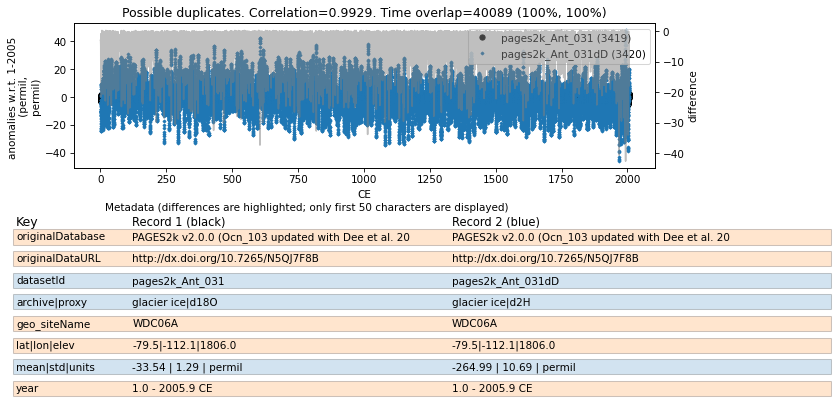

Would you like to leave a comment?


 Please type your comment here and/or press enter. d2H and d18O records, keep both
Keep record 1 (pages2k_Ant_031, black) [1], record 2 (pages2k_Ant_031dD, blue) [2], keep both [b], keep none [n] or create a composite of both records [c]?  [Type 1/2/b/n/c]: b


KEEP BOTH: keep pages2k_Ant_031, keep pages2k_Ant_031dD.
write decision to backup file
END OF DUPLICATE DECISION PROCESS.
Summary of all decisions made:
#0: REMOVE record FE23_asia_russ137w. KEEP record dod2k_composite_st_pages2k_Asia_011_pages2k_Asia_012.
#1: KEEP record iso2k_IC09OPAN01A. KEEP record pages2k_Arc_089.
#2: KEEP record pages2k_Ant_031. KEEP record pages2k_Ant_031dD.


Type your comment on your decision process here and/or press enter: repeat duplicate_detection on dupfree to check all duplicates found 2024/12/05 MNE


(3, 27)
Saved the decisions under dod2k_dupfree/dup_detection/dup_decisions_dod2k_dupfree_MNE_24-12-05.csv


In [12]:
dupdet.duplicate_decisions(df, operator_details=False, choose_recollection=True, keep_all=False,plot=True, remove_identicals=True, dist_tolerance_km=8)

In [13]:

# date =  '24-11-22'
date = str(datetime.datetime.utcnow())[2:10]
fn = f.find('dup_decisions_%s_%s_%s.csv'%(df.name, initials, date), 
     '%s/dup_detection'%df.name)


In [14]:
if fn != []:
    print('----------------------------------------------------')
    print('Sucessfully finished the duplicate decision process!'.upper())
    print('----------------------------------------------------')
    print('Saved the decision output file in:')
    print()
    for ff in fn:
        print('%s.'%ff)
    print()
    print('You are now able to proceed with the next notebook: dup_removal.ipynb')
else:
    print('!!!!!!!!!!!!WARNING!!!!!!!!!!!')
    print('Final output file is missing.')
    print()
    print('Please re-run the notebook to complete duplicate decision process.')

----------------------------------------------------
SUCESSFULLY FINISHED THE DUPLICATE DECISION PROCESS!
----------------------------------------------------
Saved the decision output file in:

dod2k_dupfree/dup_detection/dup_decisions_dod2k_dupfree_MNE_24-12-05.csv.

You are now able to proceed with the next notebook: dup_finalise.ipynb
